In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26*26*16

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24*24*32

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10,kernel_size=1,padding=0, bias=False)
        )#output = 24*24*10

        self.maxPool = nn.MaxPool2d(2,2)#output=12*12*10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding=0, bias=False),
            nn.ReLU()
        )#output= 10*10*16

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, bias=False),
            nn.ReLU()
        )#output = 8*8*32

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, bias=False),
            nn.ReLU()
        )#output = 6*6*64==>MP=3*3*64

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=3, padding=0, bias=False)
        )#1*1*10


    def forward(self, x):
        
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.maxPool(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.maxPool(x)
        x = self.convblock7(x)
      
        x = x.reshape(-1,10)

        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 10, 24, 24]             320
         MaxPool2d-6           [-1, 10, 12, 12]               0
            Conv2d-7           [-1, 16, 10, 10]           1,440
              ReLU-8           [-1, 16, 10, 10]               0
            Conv2d-9             [-1, 32, 8, 8]           4,608
             ReLU-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 64, 6, 6]          18,432
             ReLU-12             [-1, 64, 6, 6]               0
        MaxPool2d-13             [-1, 64, 3, 3]               0
           Conv2d-14             [

In [ ]:
training_MNIST_loss, training_MNIST_accuracy, testing_MNIST_accuracy, testing_MNIST_loss=[], [], [], []


def train(network, device, train_loader, optimizer, epoch):
  network.train()
  processed = 0
  total_correct = 0
  loss = 0

  for batch in train_loader:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    preds = network(images) # Pass Batch
    loss = F.nll_loss(preds, labels) # Calculate Loss
    training_MNIST_loss.append(loss.item())
    
    total_correct += get_num_correct(preds, labels)
    processed += len(labels)

    optimizer.zero_grad()
    loss.backward() # Calculate Gradients
    optimizer.step() # Update Weights
  
  training_MNIST_accuracy.append(100*total_correct/processed)

  print("Training: loss %.6f total_correct:%.2f " %(loss ,100*total_correct/processed ))

def test (network, device, test_loader):
  network.eval()
  total_correct = 0
  processed = 0
  loss = 0

  with torch.no_grad():
    for batch in test_loader:
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)
    
      preds = network(images)
      total_correct += get_num_correct(preds, labels)
      loss += F.nll_loss(preds, labels)
      processed += len(labels)

    loss = loss/len(test_loader.dataset)

    testing_MNIST_accuracy.append(100*total_correct/processed)
    testing_MNIST_loss.append(loss)
    print("Testing: loss %.6f total_correct: %.2f " %(loss ,100*total_correct/processed))


In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: loss 0.045402 total_correct:74.58 
Testing: loss 0.000647 total_correct: 97.42 
EPOCH: 1
Training: loss 0.044703 total_correct:97.40 
Testing: loss 0.000433 total_correct: 98.28 
EPOCH: 2
Training: loss 0.031244 total_correct:98.14 
Testing: loss 0.000351 total_correct: 98.64 
EPOCH: 3
Training: loss 0.030272 total_correct:98.46 
Testing: loss 0.000342 total_correct: 98.57 
EPOCH: 4
Training: loss 0.067031 total_correct:98.70 
Testing: loss 0.000289 total_correct: 98.88 
EPOCH: 5
Training: loss 0.035895 total_correct:98.99 
Testing: loss 0.000308 total_correct: 98.61 
EPOCH: 6
Training: loss 0.004218 total_correct:99.08 
Testing: loss 0.000294 total_correct: 98.89 
EPOCH: 7
Training: loss 0.033225 total_correct:99.19 
Testing: loss 0.000354 total_correct: 98.59 
EPOCH: 8
Training: loss 0.010393 total_correct:99.27 
Testing: loss 0.000265 total_correct: 98.99 
EPOCH: 9
Training: loss 0.004696 total_correct:99.31 
Testing: loss 0.000244 total_correct: 99.05 
EPOCH: 10
Training:

Text(0.5, 1.0, 'Test Accuracy')

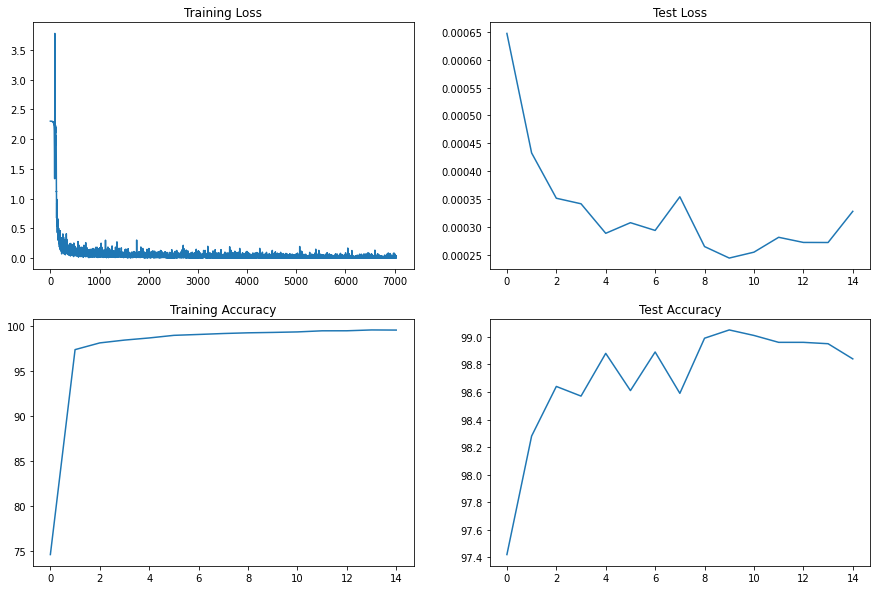

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(training_MNIST_loss)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(training_MNIST_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(testing_MNIST_loss)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(testing_MNIST_accuracy)
axs[1, 1].set_title("Test Accuracy")